# Lecture 3 (Unsupervised Learning): Clustering
Remember what we learned...?

The point here will be to figure out what our data represent...

In [10]:
### import relevant packages
import numpy as np
import scipy.stats as stats
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn as skl

In [11]:
### let's pull our data
df = pd.read_csv('Data/data_clustering.csv', header=None, skiprows=[0])
df.head()

,0,1,2,3
0,0.008485,0.103018,5.0,1751.341186
1,0.005960,0.126090,5.0,1733.537738
2,0.002525,0.152121,5.0,1738.440493
3,0.002525,0.152660,30.0,3386.088586
4,0.000808,0.150804,5.0,1756.014714


In [22]:
### let's make a new frame which helps us visualize
df_plot = df.melt(var_name='Variables', value_name='Values', ignore_index=False)
df_plot

,Variables,Values
0,0,0.008485
1,0,0.005960
2,0,0.002525
3,0,0.002525
4,0,0.000808
...,...,...
195,3,1710.753381
196,3,3353.440852
197,3,1761.444598
198,3,1741.737483


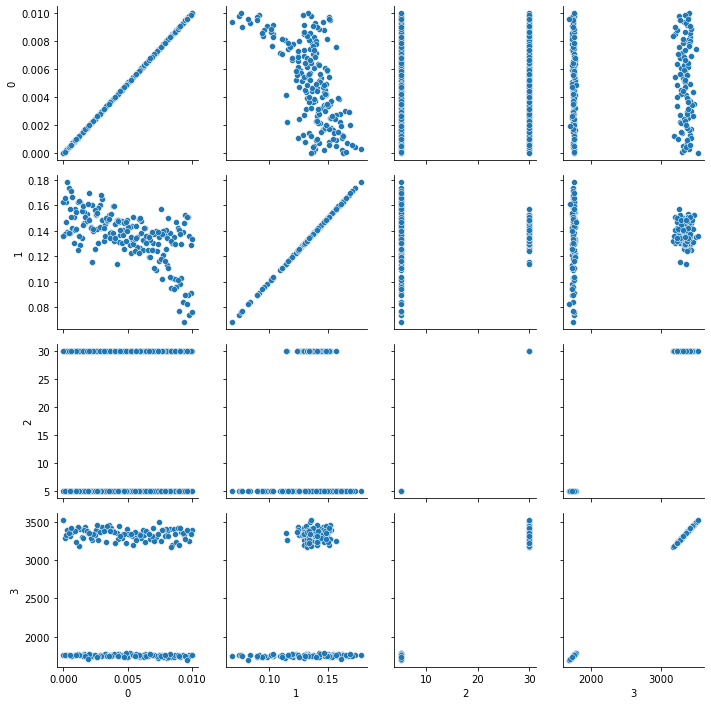

In [29]:
### let's make a pairgrid to look for patterns... what do you see?
g = sns.PairGrid(df)
g.map(sns.scatterplot)

In [ ]:
### let's make some more plots to get a closer look...

In [ ]:
### ok, let's cluster!